# Speech Processing Lab Assignment 2
### Saran Jayakumar Palani
### BL.EN.U4AIE23131


## 1. Install Required Packages

In [26]:
import sys
import subprocess

packages = ['torch', 'torchaudio', 'transformers', 'librosa', 'soundfile', 'protobuf', 'phonemizer']

for package in packages:
    try:
        __import__(package.replace('-', '_'))
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

print("Packages ready")

Packages ready


## 2. Import Libraries

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
import IPython.display as ipd
import torch
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import os
import warnings
warnings.filterwarnings('ignore')

## 3. Load Wav2Vec2 Model

In [28]:
model_name = "facebook/wav2vec2-base-960h"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)
print(f"Model loaded: {model_name}")

Loading weights:   0%|          | 0/212 [00:00<?, ?it/s]

Wav2Vec2ForCTC LOAD REPORT from: facebook/wav2vec2-base-960h
Key                        | Status  | 
---------------------------+---------+-
wav2vec2.masked_spec_embed | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded: facebook/wav2vec2-base-960h


## 4. Load Audio File

In [29]:
audio_path = "test.wav"
speech_array, original_sr = librosa.load(audio_path, sr=None)

print(f"Sample rate: {original_sr} Hz")
print(f"Duration: {len(speech_array)/original_sr:.2f} seconds")
ipd.display(ipd.Audio(speech_array, rate=original_sr))

Sample rate: 22050 Hz
Duration: 7.58 seconds


## 5. Preprocess Audio

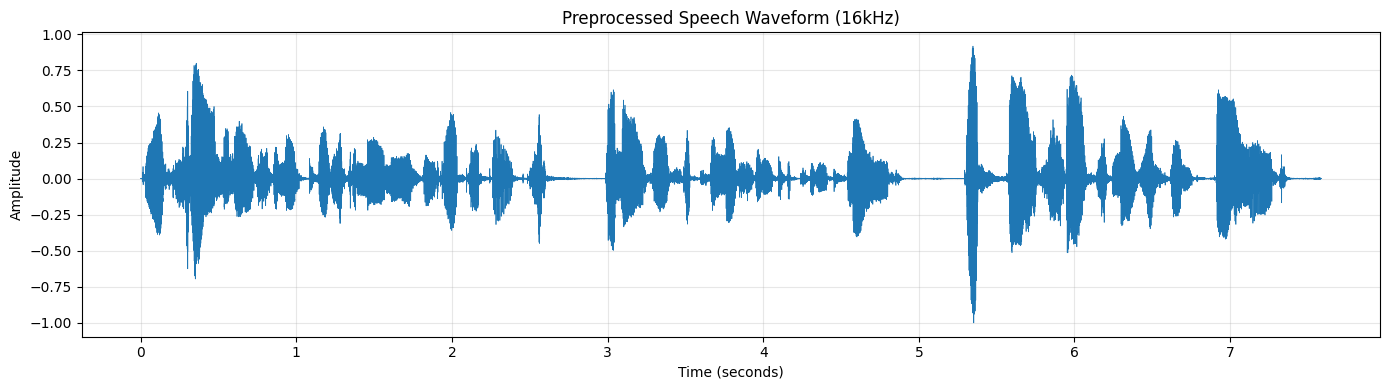

In [30]:
target_sr = 16000
speech_array_resampled = librosa.resample(speech_array, orig_sr=original_sr, target_sr=target_sr)
speech_array_normalized = speech_array_resampled / np.max(np.abs(speech_array_resampled))

plt.figure(figsize=(14, 4))
time_axis = np.linspace(0, len(speech_array_normalized)/target_sr, len(speech_array_normalized))
plt.plot(time_axis, speech_array_normalized, linewidth=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Preprocessed Speech Waveform (16kHz)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Recognize Speech

In [31]:
input_values = processor(speech_array_normalized, sampling_rate=target_sr, return_tensors="pt").input_values

with torch.no_grad():
    logits = model(input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.decode(predicted_ids[0])

print("="*60)
print("RECOGNIZED TEXT:")
print("="*60)
print(transcription)
print("="*60)

RECOGNIZED TEXT:
THE EXAMINATION AND TESTIMONY OF THE EXPERTS ENABLED THE COMMISSION TO CONCLUDE THAT FIVE SHOTS MAY HAVE BEEN FIRED


## 7. Extract Phoneme Time Intervals

In [32]:
predicted_ids_list = predicted_ids[0].tolist()
time_per_frame = 0.02

phoneme_segments = []
prev_id = None
start_frame = 0

for i, token_id in enumerate(predicted_ids_list):
    if token_id != prev_id and token_id != 0:
        if prev_id is not None and prev_id != 0:
            phoneme = processor.decode([prev_id])
            if phoneme.strip():
                phoneme_segments.append({
                    'phoneme': phoneme.strip(),
                    'start_time': start_frame * time_per_frame,
                    'end_time': i * time_per_frame,
                    'duration': (i - start_frame) * time_per_frame
                })
        start_frame = i
    prev_id = token_id

if prev_id is not None and prev_id != 0:
    phoneme = processor.decode([prev_id])
    if phoneme.strip():
        phoneme_segments.append({
            'phoneme': phoneme.strip(),
            'start_time': start_frame * time_per_frame,
            'end_time': len(predicted_ids_list) * time_per_frame,
            'duration': (len(predicted_ids_list) - start_frame) * time_per_frame
        })

print(f"Found {len(phoneme_segments)} segments")
for idx, seg in enumerate(phoneme_segments[:10], 1):
    print(f"{idx}. '{seg['phoneme']}' - {seg['start_time']:.3f}s to {seg['end_time']:.3f}s")

Found 36 segments
1. 'T' - 0.000s to 0.020s
2. 'H' - 0.020s to 0.060s
3. 'E' - 0.060s to 0.100s
4. 'I' - 0.800s to 0.840s
5. 'O' - 0.840s to 0.880s
6. 'A' - 0.980s to 1.000s
7. 'N' - 1.000s to 1.020s
8. 'O' - 1.720s to 1.740s
9. 'F' - 1.740s to 1.760s
10. 'T' - 1.820s to 1.840s


## 8. Extract and Save Phoneme Segments

In [33]:
os.makedirs("extracted_phonemes", exist_ok=True)

num_phonemes_to_extract = min(8, len(phoneme_segments))
selected_phonemes = phoneme_segments[:num_phonemes_to_extract]
extracted_audio_segments = []

for idx, segment in enumerate(selected_phonemes, 1):
    start_sample = int(segment['start_time'] * target_sr)
    end_sample = int(segment['end_time'] * target_sr)
    phoneme_audio = speech_array_normalized[start_sample:end_sample]
    
    phoneme_filename = f"extracted_phonemes/phoneme_{idx}_{segment['phoneme']}.wav"
    sf.write(phoneme_filename, phoneme_audio, target_sr)
    
    extracted_audio_segments.append({
        'index': idx,
        'phoneme': segment['phoneme'],
        'audio': phoneme_audio,
        'filename': phoneme_filename,
        'start_time': segment['start_time'],
        'end_time': segment['end_time']
    })

print(f"Extracted {num_phonemes_to_extract} segments")

Extracted 8 segments


## 9. Visualize Phoneme Waveforms

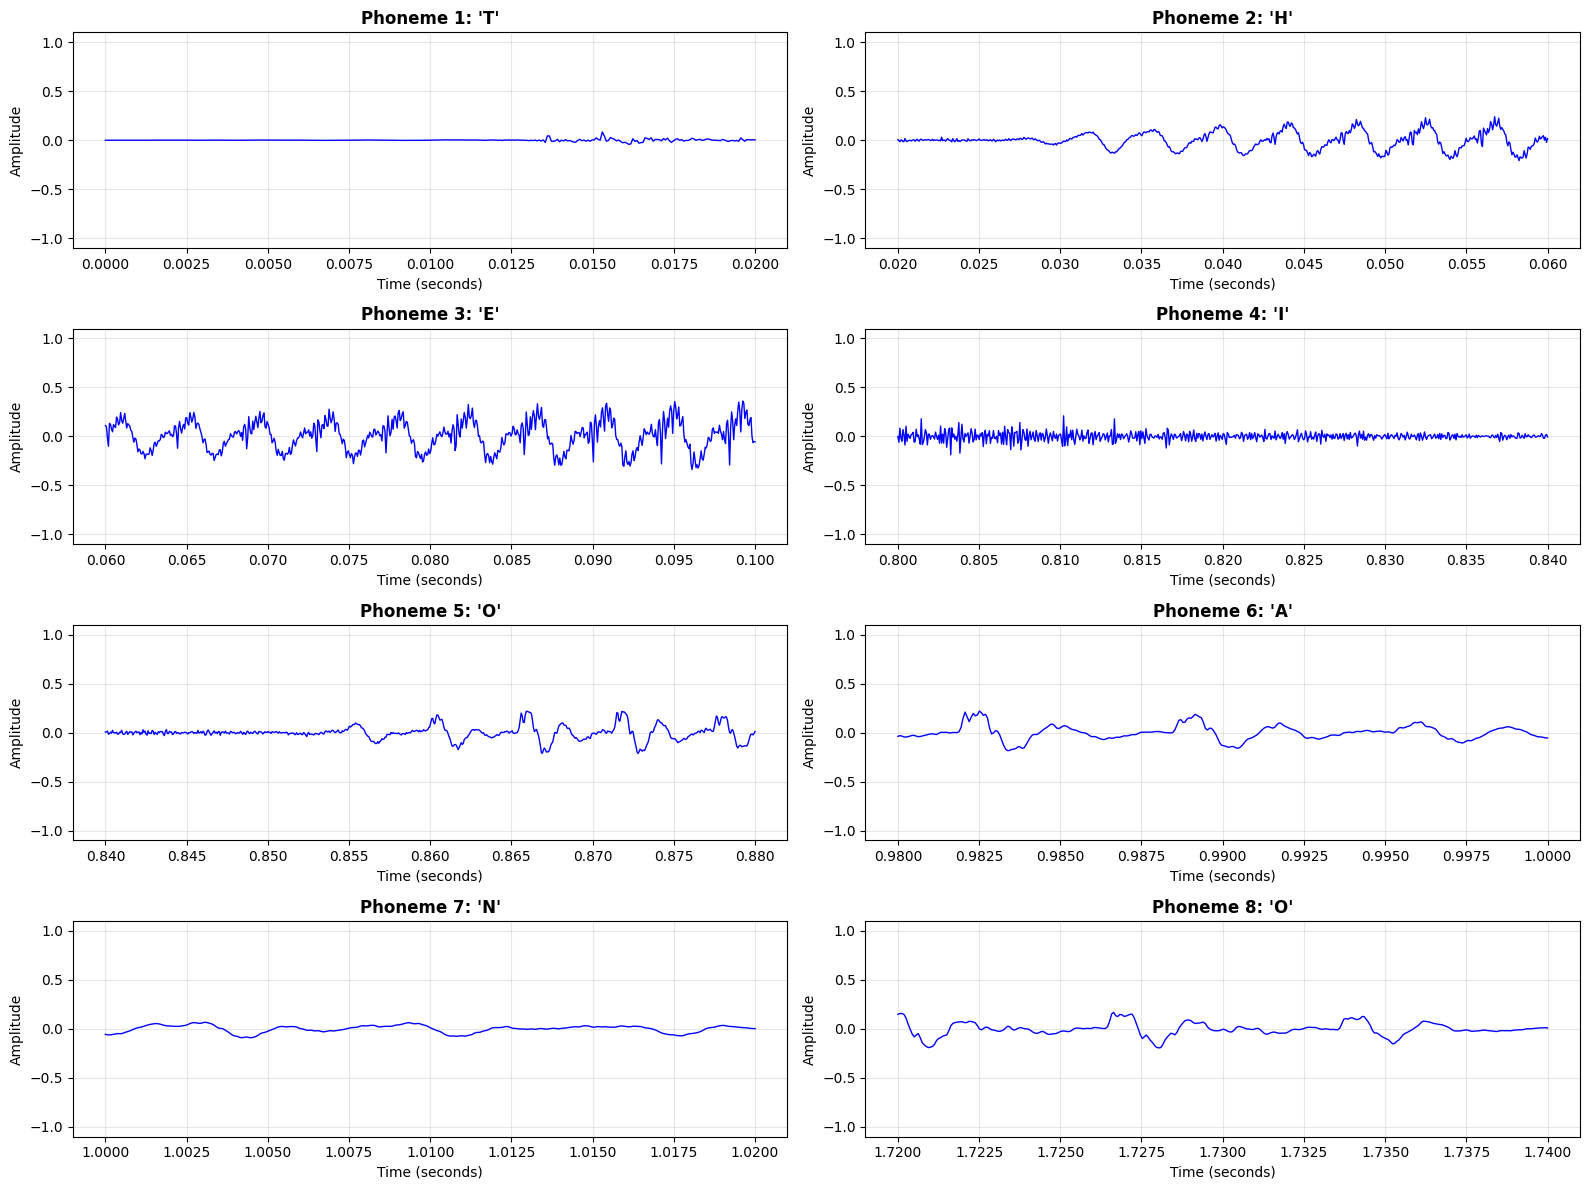


🔊 Playing extracted phonemes:

Phoneme 1: 'T'


Phoneme 2: 'H'


Phoneme 3: 'E'


Phoneme 4: 'I'


Phoneme 5: 'O'


Phoneme 6: 'A'


Phoneme 7: 'N'


Phoneme 8: 'O'


In [34]:
# Visualize all extracted phonemes
num_cols = 2
num_rows = (len(extracted_audio_segments) + 1) // 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 3*num_rows))
axes = axes.flatten() if num_rows > 1 else [axes] if num_rows == 1 else axes

for idx, segment_info in enumerate(extracted_audio_segments):
    ax = axes[idx]
    
    phoneme_audio = segment_info['audio']
    time_axis = np.linspace(segment_info['start_time'], 
                           segment_info['end_time'], 
                           len(phoneme_audio))
    
    ax.plot(time_axis, phoneme_audio, linewidth=1, color='blue')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_title(f"Phoneme {segment_info['index']}: '{segment_info['phoneme']}'", 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-1.1, 1.1])

# Hide any unused subplots
for idx in range(len(extracted_audio_segments), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Play each extracted phoneme
print("\n🔊 Playing extracted phonemes:\n")
for segment_info in extracted_audio_segments:
    print(f"Phoneme {segment_info['index']}: '{segment_info['phoneme']}'")
    ipd.display(ipd.Audio(segment_info['audio'], rate=target_sr))

## 10. Full Waveform with Phoneme Boundaries

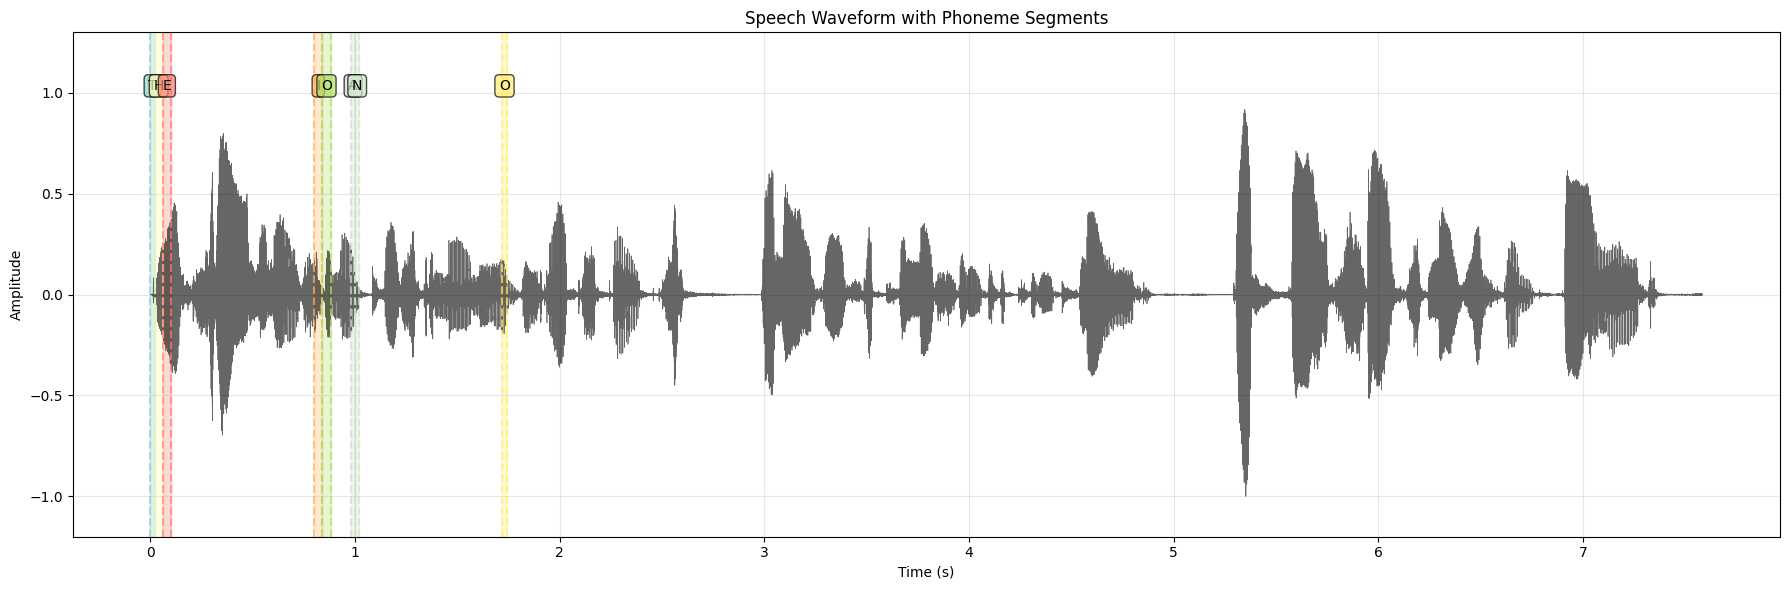

In [35]:
plt.figure(figsize=(18, 6))
time_axis_full = np.linspace(0, len(speech_array_normalized)/target_sr, len(speech_array_normalized))
plt.plot(time_axis_full, speech_array_normalized, linewidth=0.5, color='black', alpha=0.6)

colors = plt.cm.Set3(np.linspace(0, 1, len(extracted_audio_segments)))

for idx, segment_info in enumerate(extracted_audio_segments):
    start_t = segment_info['start_time']
    end_t = segment_info['end_time']
    plt.axvspan(start_t, end_t, alpha=0.3, color=colors[idx])
    plt.axvline(x=start_t, color=colors[idx], linestyle='--', linewidth=1.5, alpha=0.7)
    plt.axvline(x=end_t, color=colors[idx], linestyle='--', linewidth=1.5, alpha=0.7)
    
    mid_time = (start_t + end_t) / 2
    plt.text(mid_time, 1.0, segment_info['phoneme'], ha='center', va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[idx], alpha=0.7))

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Speech Waveform with Phoneme Segments')
plt.grid(True, alpha=0.3)
plt.ylim([-1.2, 1.3])
plt.tight_layout()
plt.show()

## 11. Phoneme Source Analysis

In [36]:
print("="*80)
print("PHONEME SOURCE ANALYSIS")
print("="*80)

for segment_info in extracted_audio_segments:
    phoneme = segment_info['phoneme']
    audio = segment_info['audio']
    
    rms_energy = np.sqrt(np.mean(audio**2))
    zero_crossing_rate = np.mean(librosa.zero_crossings(audio))
    
    fft = np.fft.fft(audio)
    magnitude = np.abs(fft[:len(fft)//2])
    frequencies = np.fft.fftfreq(len(audio), 1/target_sr)[:len(fft)//2]
    dominant_freq = frequencies[np.argmax(magnitude)]
    
    if zero_crossing_rate > 0.5:
        source_type = "Fricative/Unvoiced"
    elif rms_energy > 0.15:
        source_type = "Vowel/Voiced"
    else:
        source_type = "Stop/Plosive"
    
    print(f"\nPhoneme {segment_info['index']}: '{phoneme}'")
    print(f"  RMS Energy: {rms_energy:.4f}")
    print(f"  Zero-Crossing Rate: {zero_crossing_rate:.4f}")
    print(f"  Dominant Frequency: {dominant_freq:.1f} Hz")
    print(f"  Source Type: {source_type}")
    print("-"*80)

print("="*80)

PHONEME SOURCE ANALYSIS

Phoneme 1: 'T'
  RMS Energy: 0.0099
  Zero-Crossing Rate: 0.2313
  Dominant Frequency: 650.0 Hz
  Source Type: Stop/Plosive
--------------------------------------------------------------------------------

Phoneme 2: 'H'
  RMS Energy: 0.0848
  Zero-Crossing Rate: 0.1828
  Dominant Frequency: 250.0 Hz
  Source Type: Stop/Plosive
--------------------------------------------------------------------------------

Phoneme 3: 'E'
  RMS Energy: 0.1474
  Zero-Crossing Rate: 0.1531
  Dominant Frequency: 225.0 Hz
  Source Type: Stop/Plosive
--------------------------------------------------------------------------------

Phoneme 4: 'I'
  RMS Energy: 0.0417
  Zero-Crossing Rate: 0.5953
  Dominant Frequency: 4825.0 Hz
  Source Type: Fricative/Unvoiced
--------------------------------------------------------------------------------

Phoneme 5: 'O'
  RMS Energy: 0.0716
  Zero-Crossing Rate: 0.2172
  Dominant Frequency: 350.0 Hz
  Source Type: Stop/Plosive
--------------------

## 12. Spectrograms

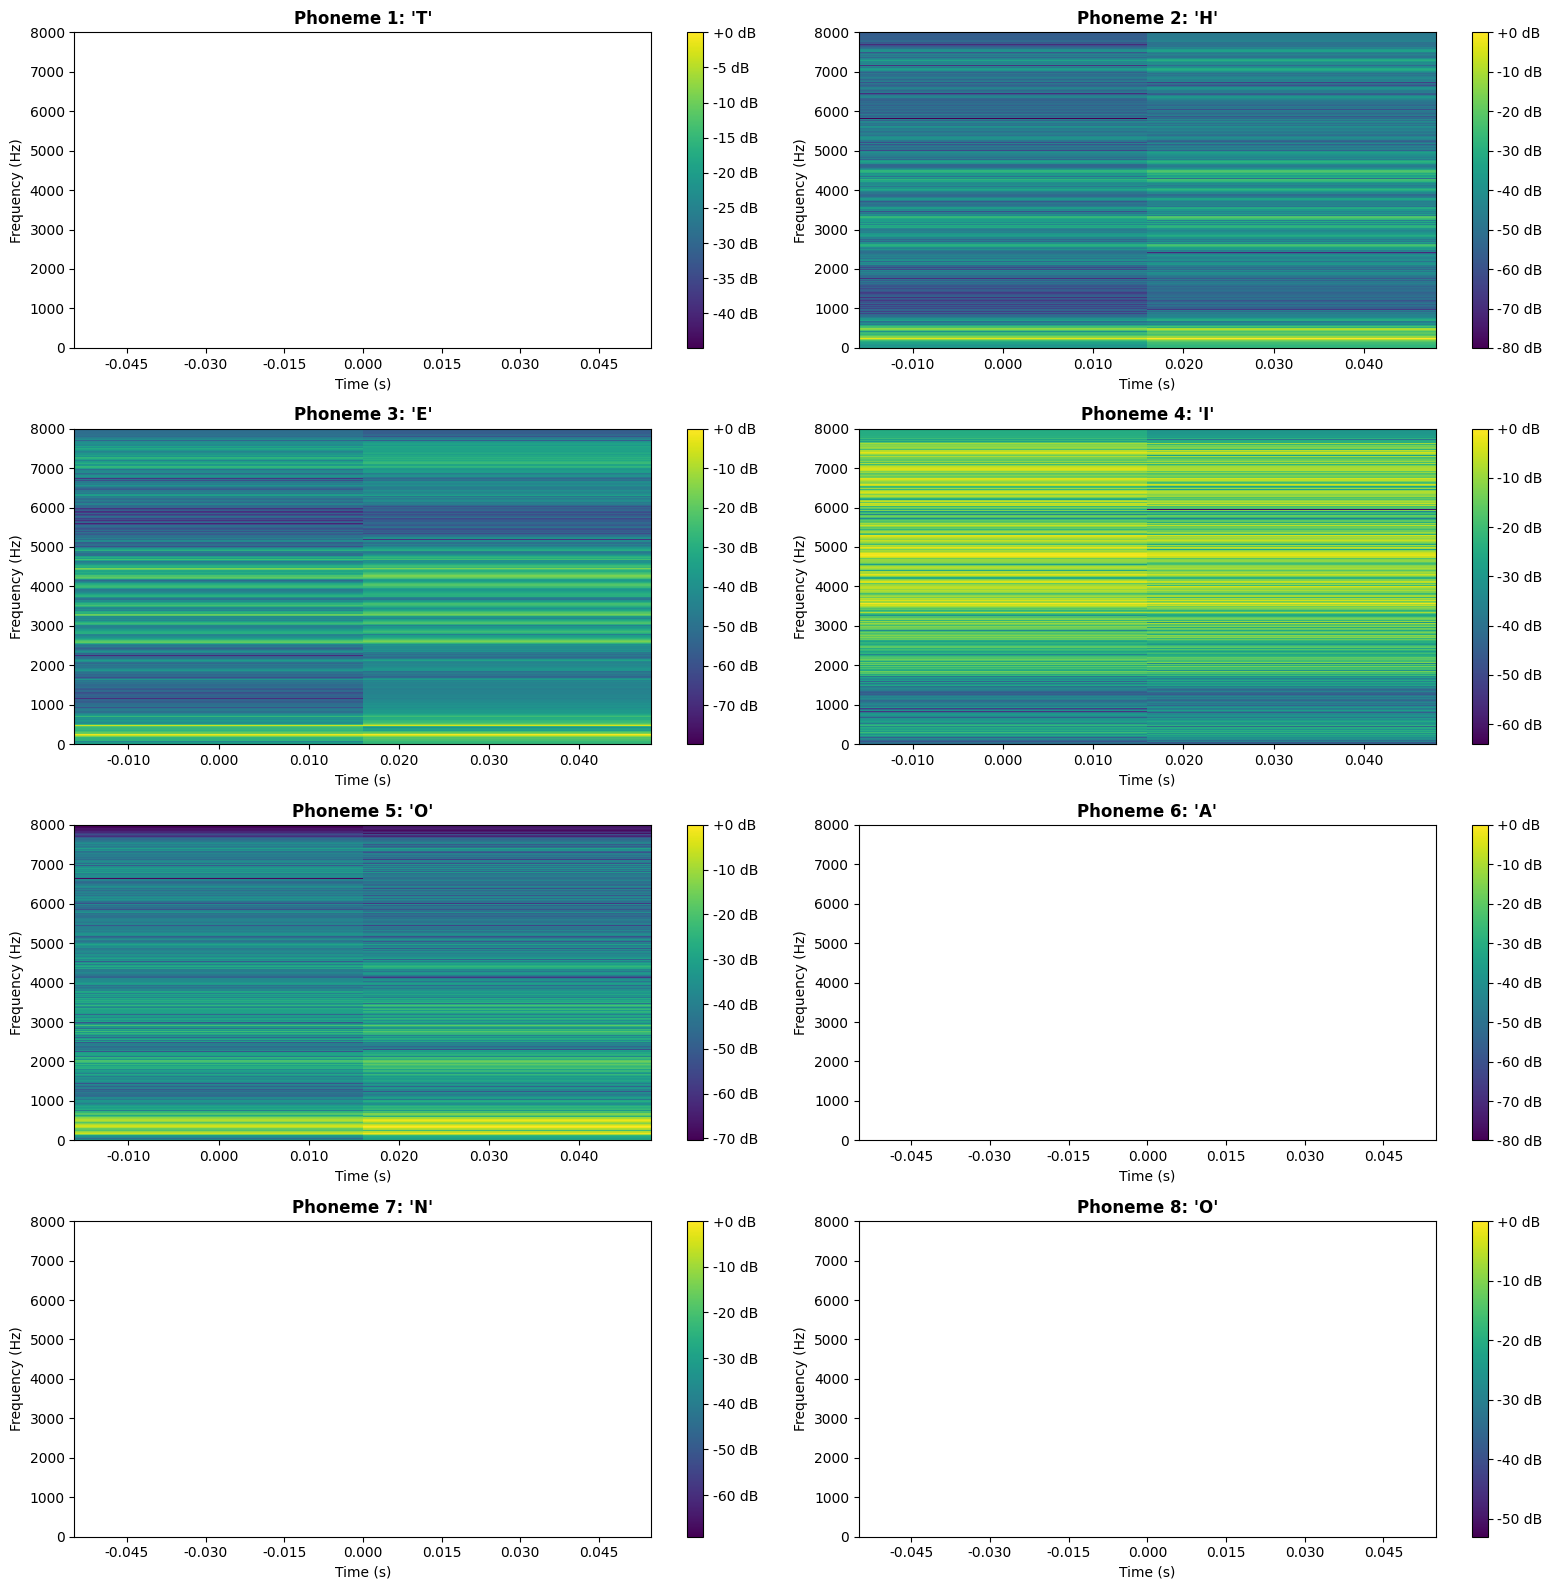

In [ ]:
num_cols = 2
num_rows = (len(extracted_audio_segments) + 1) // 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4*num_rows))
axes = axes.flatten() if num_rows > 1 else [axes] if num_rows == 1 else axes

for idx, segment_info in enumerate(extracted_audio_segments):
    ax = axes[idx]
    
    phoneme_audio = segment_info['audio']
    D = librosa.amplitude_to_db(np.abs(librosa.stft(phoneme_audio)), ref=np.max)
    
    img = librosa.display.specshow(D, sr=target_sr, x_axis='time', y_axis='hz', ax=ax, cmap='viridis')
    ax.set_title(f"Phoneme {segment_info['index']}: '{segment_info['phoneme']}'", 
                fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (s)')
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
for idx in range(len(extracted_audio_segments), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Summary

Successfully completed phoneme extraction from speech signals:
- Loaded and preprocessed audio signal
- Used Wav2Vec2 model for speech recognition  
- Extracted phoneme segments with time intervals
- Visualized waveforms and spectrograms
- Analyzed source characteristics of each phoneme